In [6]:
# usr/bin/env python
__author__ = "Sandeep kumar Nayak"
__email__ = "nayak.sandeep@rm.is.tohoku.ac.jp"
__copyright__ = "Copyright 2020, Tadokoro Lab"

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}

matplotlib.rc('font', **font)
# %matplotlib inline 
import seaborn as sns;sns.set()
import sys
import os
from os.path import expanduser
import math

##____________COMMON FUNCTIONS __________________________--
## Common Class

import pandas as pd
class Datetime_Dataframe:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
    
  
    
    def time_col_concat(self,col1,col2,new_col_name):
        if self.df[col1].dtype == 'int64':
            self.df[col1]= self.df[col1].astype(str)
        if self.df[col2].dtype == 'int64':
            self.df[col2] = self.df[col2].astype(str)
        temp = self.df[col1] + self.df[col2]
        temp = temp.astype('int64')
        try:
            self.df.insert(1,new_col_name,temp)
        except: 
            pass
        return self.df
        
    def time_diff(self, time_col, ref_time, new_col_name):
        
        temp_nano = self.df[time_col] - ref_time
        temp_milli = temp_nano*math.pow(10,-6)
        temp = temp_nano*math.pow(10,-9)
        try:
            self.df.insert(2,new_col_name,temp)
            self.df.insert(3,new_col_name+"milli",temp_milli)
            self.df.insert(4,new_col_name+"nano",temp_nano)
        except:
            pass
        return self.df


def interval_extractor(time_column, start_time, end_time, df, column):
    """# Exctract only the column defined by start_time, end_time column. """
    df_list = list(df.loc[:,time_column])
    final_list = [] 
    for index, time in enumerate(df_list):
        if time >= start_time and time <= end_time:
            final_list.append(df.loc[index,column])
    return final_list

def velocity_calc(time_column,start_time, end_time,df,column_x,column_y):

#  distance = math.sqrt(pow(waypoint.pose.pose.position.x-animal_pose.pose.pose.position.x,2)+pow(waypoint.pose.pose.position.y-animal_pose.pose.pose.position.y,2))
    df_list=list(df.loc[:,time_column])
    velocity_list_x = []
    velocity_list_y = []
    velocity_list_net = []
    velocity_time = []
    for index,time in enumerate(df_list):        
        if time >= start_time and time <= end_time:
            if index==0:
                pass
            else:                
                velocity_time.append(time)
                velocity_x=(df.loc[index,column_x]-df.loc[index-1,column_x])/(df.loc[index,time_column] - df.loc[index-1,time_column])
                # Converting into m/s
                velocity_x = velocity_x * pow(10,9)
                velocity_list_x.append(velocity_x)

                velocity_y=(df.loc[index,column_y]-df.loc[index-1,column_y])/(df.loc[index,time_column] - df.loc[index-1,time_column])
                # Converting into m/s
                velocity_y = velocity_y * pow(10,9)
                velocity_list_y.append(velocity_y)

                velocity_list_net.append(math.sqrt(pow(velocity_x,2)+pow(velocity_y,2)))
    out_df = pd.DataFrame(list(zip(velocity_time,velocity_list_net,velocity_list_x,velocity_list_y)),columns=["velocity_time","velocity_list_net","velocity_list_x","velocity_list_y"])
    # return velocity_list_net,velocity_list_x,velocity_list_y,velocity_time
    return out_df


def euclidean_distance_calc(x_list,y_list):
    distance = 0
    # Assuming lenght of x_list & y_list are same
    try:
        if len(x_list) == len(y_list):
            for index,x in enumerate(x_list):
                if index == 0:
                    pass
                else:
                    distance += math.sqrt(pow(x_list[index]-x_list[index-1],2)+pow(y_list[index]-y_list[index-1],2))
        else:
            raise IndexError("List provided is not same length")
    except IndexError:
        pass
    return distance




end
waypoint_distance 42.007537359885326
trajectory_distance 48.414177441073214
TDR 15.251167966122775
navigation_time 108.86040222400001


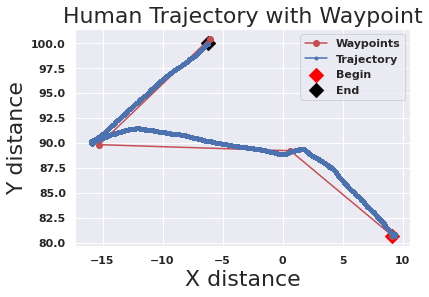

In [7]:
home = expanduser("~")
# dir_path = home + '/Animal_Navigation/data/tamura/'
dir_path = os.getcwd() + "/"
file_path = "2020-11-25-18-09-37"


state_path = dir_path + file_path + '/_slash_state.csv' 
waypoint_path = dir_path + file_path + '/_slash_move_base_slash_goal.csv' 
trajectory_path = dir_path + file_path + '/_slash_map_slash_robot_pose.csv' 
signal_path = dir_path + file_path + '/_slash_cmd_sig.csv'

time_column = "rosbagTimestamp"
start_time = 0
end_time = 0
state_df = pd.read_csv(state_path)
waypoint_df = pd.read_csv(waypoint_path)
trajectory_df = pd.read_csv(trajectory_path)


# Geeting the start time & end time from state_df.
state_df.loc[:,time_column]
state_list = list(state_df.loc[:,'state'])

for index,state in enumerate(state_list):
    if state == 1 :
        
        start_time = state_df.loc[index,time_column]
        print("start")
        
    if state == 2 : 
        
        end_time = state_df.loc[index,time_column]
        print("end")


# If there is no start_time / end_time, then make the starting time or end time.
if not start_time :
    start_time = trajectory_df[time_column].iloc[0]
if not end_time :
    end_time = trajectory_df[time_column].iloc[-1]
    

waypoint_list_x = list(waypoint_df.loc[:,'x'])
waypoint_list_y = list(waypoint_df.loc[:,'y'])
# Trying to add waypoint list to include the starting positoin as well. 
for index,time in enumerate(list(trajectory_df[time_column])):
    start_coordinate = []
    if time >= start_time:
        start_coordinate.append(trajectory_df["x"].iloc[index])
        start_coordinate.append(trajectory_df["y"].iloc[index])
        break 
waypoint_list_x.insert(0,start_coordinate[0])
waypoint_list_y.insert(0,start_coordinate[1])




# Now, this list is extracted based on the start_time & end_time. 
trajectory_list_x = interval_extractor(time_column,start_time,end_time,trajectory_df,'x')
trajectory_list_y = interval_extractor(time_column,start_time,end_time,trajectory_df,'y')



# # velocity_list_net,velocity_list_x,velocity_list_y,velocity_time = velocity_calc(time_column,start_time,end_time,trajectory_df,"x","y")
# velocity_df = velocity_calc(time_column,start_time,end_time,trajectory_df,"x","y")


# Measure of Deviation 1
waypoint_distance = euclidean_distance_calc(waypoint_list_x,waypoint_list_y)
trajectory_distance = euclidean_distance_calc(trajectory_list_x,trajectory_list_y)
print ("waypoint_distance",waypoint_distance)
print ("trajectory_distance",trajectory_distance)
trajectory_ratio = (((trajectory_distance-waypoint_distance)/waypoint_distance))*100
# Trajectory Deviation Ratio : TDR 
print ("TDR",trajectory_ratio)

# Navigation time evaluation: 
navigation_time = (end_time - start_time) * pow(10,-9)
print ("navigation_time",navigation_time)



image_path = dir_path+file_path+"/"+file_path+".png"
output_path =  dir_path+file_path+"/"+file_path+".txt"
with open(output_path, 'w') as f:
    # f.write("waypoint_distance",waypoint_distance)
    print ("waypoint_distance: {} ".format(waypoint_distance),file=f)    # Python 3.x
    print ("trajectory_distance: {} ".format(trajectory_distance),file=f)    # Python 3.x
    print ("TDR: {} ".format(trajectory_ratio),file=f)    # Python 3.x
    print ("navigation_time: {} ".format(navigation_time),file=f)    # Python 3.x
   

#____PLOTTING_____###
fig, ax = plt.subplots()
ax.plot(waypoint_list_x,waypoint_list_y,'ro-',label="Waypoints")
ax.plot(trajectory_list_x,trajectory_list_y,'b.-',label="Trajectory")
plt.xlabel('X distance',fontsize=22)
plt.ylabel('Y distance',fontsize=22)
#Plotting startig & ending poistions 
ax.scatter(trajectory_list_x[0],trajectory_list_y[0],s=100,marker='D',c='red',label = "Begin")
ax.scatter(trajectory_list_x[-1],trajectory_list_y[-1],s=100,marker='D',c='black',label = "End")
plt.title("Human Trajectory with Waypoint",fontsize=22)
plt.legend()
plt.savefig(image_path,bbox_inches='tight')
plt.show()


In [86]:
# Data Summary 
print(trajectory_df.describe())
print(trajectory_df.dtypes)
print(trajectory_df.columns)
  # # joy_final_df.memory_usage()
    # print(joy_final_df.max())
for index, val in enumerate(trajectory_df.columns):
    print ("{}:{}".format(index,val), end=" , ")
# 0:rosbagTimestamp , 1:header , 2:seq , 3:stamp , 4:secs , 5:nsecs , 6:frame_id , 
# 7:pose , 8:pose.1 , 9:position , 10:x , 11:y , 12:z , 13:orientation , 14:x.1 , 
#                             15:y.1 , 16:z.1 , 17:w , 18:covariance 


       rosbagTimestamp  header            seq  stamp          secs  \
count     3.888300e+04     0.0   38883.000000    0.0  3.888300e+04   
mean      1.606295e+18     NaN  490799.000000    NaN  1.606295e+09   
std       5.612236e+10     NaN   11224.699595    NaN  5.613819e+01   
min       1.606295e+18     NaN  471358.000000    NaN  1.606295e+09   
25%       1.606295e+18     NaN  481078.500000    NaN  1.606295e+09   
50%       1.606295e+18     NaN  490799.000000    NaN  1.606295e+09   
75%       1.606296e+18     NaN  500519.500000    NaN  1.606296e+09   
max       1.606296e+18     NaN  510240.000000    NaN  1.606296e+09   

              nsecs  pose  pose.1  position             x             y  \
count  3.888300e+04   0.0     0.0       0.0  38883.000000  38883.000000   
mean   5.008862e+08   NaN     NaN       NaN     -1.769355     86.533586   
std    2.944629e+08   NaN     NaN       NaN      8.226737      6.051403   
min    2.829616e+07   NaN     NaN       NaN    -15.987244     80.6380

In [87]:
trajectory_df.head(1)

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,pose.1,position,x,y,z,orientation,x.1,y.1,z.1,w,covariance
0,1606295379778546741,NaN,471358,NaN,1606295379,329066840,"""map""",NaN,NaN,NaN,9.132759,80.69424,2.0,NaN,-0.696802,-0.676601,0.161537,-0.174882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [88]:
# checking Data  for Nan values. 
# print(trajectory_df.isnull().sum())

# # Data Cleaning  
# class Clean_df(object):
#     def __init__(self,df,col_list):
#         self.df = df
#         self.col_list = col_list    
    

In [89]:
# converting & appending the time into multiple format for simplification of functions later. 
class Datetime_Dataframe:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
    
  
    
    def time_col_concat(self,col1,col2,new_col_name):
        if self.df[col1].dtype == 'int64':
            self.df[col1]= self.df[col1].astype(str)
        if self.df[col2].dtype == 'int64':
            self.df[col2] = self.df[col2].astype(str)
        temp = self.df[col1] + self.df[col2]
        temp = temp.astype('int64')
        try:
            self.df.insert(1,new_col_name,temp)
        except: 
            pass
        return self.df
        
    def time_diff(self, time_col, ref_time, new_col_name):
        
        temp_nano = self.df[time_col] - ref_time
        temp_milli = temp_nano*math.pow(10,-6)
        temp = temp_nano*math.pow(10,-9)
        try:
            self.df.insert(2,new_col_name,temp)
            self.df.insert(3,new_col_name+"milli",temp_milli)
            self.df.insert(4,new_col_name+"nano",temp_nano)
        except:
            pass
        return self.df
        

In [90]:
# SLICKING TRAJECTORY DF 
trajectory_df.head(1)
print(trajectory_df.shape)
trajectory_df=trajectory_df[trajectory_df["rosbagTimestamp"] > start_time ]
trajectory_df=trajectory_df[trajectory_df["rosbagTimestamp"] < end_time ]
print(trajectory_df.shape)


(38883, 19)
(21871, 19)


In [91]:
# trajectory_df.loc[:,"secs"].describe
# trajectory_df.loc[:,"secs"].dtype
# if trajectory_df["secs"].dtype == 'int64':
#     print("True")
#     trajectory_df["secs"] = trajectory_df["secs"].astype(str)
#     print(trajectory_df["secs"].dtype)
# if trajectory_df["nsecs"].dtype == 'int64':
#     print("True")
#     trajectory_df["nsecs"] = trajectory_df["nsecs"].astype(str)   
    
# print(trajectory_df["secs"][0])
# print(trajectory_df["nsecs"][0])
# temp = trajectory_df["secs"] + trajectory_df["nsecs"]
# print(temp[0])
# print(type(trajectory_df["nsecs"][0]))
# type(trajectory_df["secs"])
sensor_time = "sensor_time"
rosbag_time = "rosbagTimestamp"
ref_time = start_time
time_diff = "time_diff"
time_convert_obj = Datetime_Dataframe(trajectory_df)
new_trajectory_df=time_convert_obj.time_col_concat("secs","nsecs",sensor_time)
new_trajectory_df=time_convert_obj.time_diff(rosbag_time,ref_time,time_diff)
new_trajectory_df.head(1)
# new_trajectory_df.iloc[0:1000,2] * math.pow(10,-6)
# new_trajectory_df.iloc[0:1000,2] * math.pow(10,-9)


,rosbagTimestamp,sensor_time,time_diff,time_diffmilli,time_diffnano,header,seq,stamp,secs,nsecs,...,position,x,y,z,orientation,x.1,y.1,z.1,w,covariance
1,1606295379778562832,1606295379329066840,0.000016,0.016091,16091,NaN,471359,NaN,1606295379,329066840,...,NaN,9.132759,80.69424,2.0,NaN,-0.699378,-0.673762,0.163187,-0.174026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [92]:
# print(new_trajectory_df.columns)
# print(new_trajectory_df.shape)
# print(new_trajectory_df.describe())
# new_trajectory_df["sensor_time"] = new_trajectory_df["sensor_time"] 
# print(new_trajectory_df["sensor_time"].min())
# print(new_trajectory_df["sensor_time"].min() - ref_time)
# print(new_trajectory_df["sensor_time"].max())
# print(new_trajectory_df["sensor_time"].max() - ref_time)

print(new_trajectory_df["rosbagTimestamp"].min())
print(new_trajectory_df["rosbagTimestamp"].min() - ref_time)
print(new_trajectory_df["rosbagTimestamp"].max())
print(new_trajectory_df["rosbagTimestamp"].max() - ref_time)

1606295379778562832
16091
1606295488636339249
108857792508


In [93]:
from scipy.spatial.transform import Rotation 
euler_name = ["roll","pitch","yaw"]
quat_name = ["x.1","y.1","z.1","w"]

quat_df = new_trajectory_df.loc[: , "x.1":"w"]
quat_df
rot = Rotation.from_quat(quat_df)
rot_euler = rot.as_euler('xyz', degrees=True)
euler_df = pd.DataFrame(data=rot_euler, columns=euler_name)
euler_trajectory_df=new_trajectory_df.join(euler_df)
euler_trajectory_df.describe()
# euler_trajectory_df.tail()
# euler_trajectory_df.isnull().sum()
euler_trajectory_df['time_diff'].min()



1.6091000000000002e-05

In [94]:
euler_trajectory_df=euler_trajectory_df.drop_duplicates(subset="nsecs")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(1036, 26)


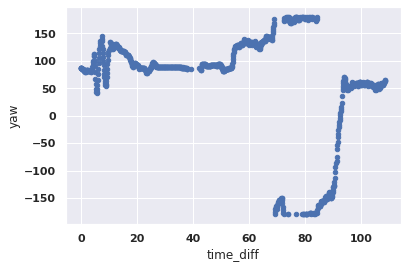

In [95]:
euler_trajectory_df.plot(x='time_diff',y='yaw',kind='scatter')
print(euler_trajectory_df.shape)

In [96]:
# Plotting the Left signal graph to time_diff gdata 
signal_path = dir_path + file_path + '/_slash_cmd_sig.csv'
left_sig = "left"
right_sig = "right"
forward_sig = "forward"
stop_sig = "stop"


signal_df = pd.read_csv(signal_path)
signal_df.head(1)

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,left,right,forward,stop,sound,state
0,1606295379778515675,NaN,847,NaN,1606295379,329066840,"""map""",1,0,0,0,0,0


In [97]:
signal_df=signal_df[signal_df["rosbagTimestamp"] > start_time ]
signal_df=signal_df[signal_df["rosbagTimestamp"] < end_time ]
signal_df = signal_df.drop_duplicates(subset="nsecs")
signal_df.shape
signal_df.head()


,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,left,right,forward,stop,sound,state
4,1606295379778549643,NaN,851,NaN,1606295379,329066840,"""map""",1,0,0,0,0,0
9,1606295379778588088,NaN,856,NaN,1606295379,433929773,"""map""",1,0,0,0,0,0
29,1606295379779378275,NaN,876,NaN,1606295379,529790645,"""map""",1,0,0,0,0,0
52,1606295379780117648,NaN,899,NaN,1606295379,634087016,"""map""",1,0,0,0,0,0
69,1606295379780424925,NaN,916,NaN,1606295379,728485137,"""map""",1,0,0,0,0,0


In [98]:
# Time transformation of signal_df 
rosbag_time = "rosbagTimestamp"
ref_time = start_time
time_diff = "time_diff"
time_convert_obj2 = Datetime_Dataframe(signal_df)
signal_df=time_convert_obj2.time_diff(rosbag_time,ref_time,new_col_name=time_diff)
signal_df.head(1)

,rosbagTimestamp,header,time_diff,time_diffmilli,time_diffnano,seq,stamp,secs,nsecs,frame_id,left,right,forward,stop,sound,state
4,1606295379778549643,NaN,0.000003,0.002902,2902,851,NaN,1606295379,329066840,"""map""",1,0,0,0,0,0


(1036, 16)


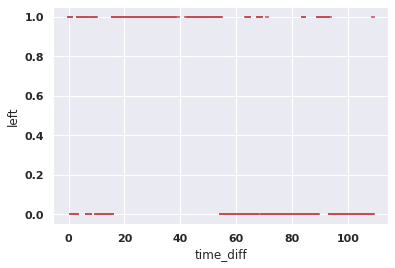

In [99]:
signal_df.plot(x='time_diff',y=left_sig,kind='scatter',marker='_',color='r')
print(signal_df.shape)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


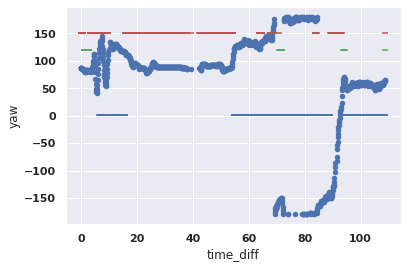

In [100]:

ax = euler_trajectory_df.plot(x='time_diff',y='yaw',kind='scatter')
# signal_df.plot(x='time_diff',y=left_sig,kind='scatter',marker='_',color='r',ax=ax)
# signal_df[signal_df["rosbagTimestamp"] > start_time ]
left_df = signal_df[signal_df[left_sig] > 0]
right_df = signal_df[signal_df[right_sig] > 0]
forward_df = signal_df[signal_df[forward_sig] > 0]

ax.scatter(left_df['time_diff'],left_df[left_sig]*150,color='r',marker='_')
ax.scatter(right_df['time_diff'],right_df[right_sig]*120,color='g',marker='_')
ax.scatter(forward_df['time_diff'],forward_df[forward_sig],color='b',marker='_')

In [101]:
def value_extract(df,ref_time, val_col_name, time_col_name):
    for i,column in df.iterrows():
        if column[time_col_name] > ref_time: 
            return column[val_col_name]

In [102]:
state = 0
angle_list = []
time_col_name = "rosbagTimestamp"
column_name = "left"
angle_col_name = "yaw"
for i,column in signal_df.iterrows():
    

#     print(column[time_col_name])
#     type(j['rosbagTimestamp'])
#     print(j['rosbagTimestamp'])
        #state 0 , 1:0->1, 2: 1->1, 3:1->0
    
    
    if column[column_name] == 1 and state==0:
        state = 1
        time = column[time_col_name]
#         print("state changede to {},{}".format(state,time))
        prev_angle = value_extract(euler_trajectory_df,ref_time,angle_col_name,time_col_name)
    
    if column[column_name] == 0 and state==1:
        now_angle = value_extract(euler_trajectory_df,column[time_col_name],angle_col_name,time_col_name)
        angle_diff = now_angle - prev_angle
        angle_list.append(angle_diff)
#         print(angle_diff)
        state = 0
print(angle_list)

[-6.124739651875146, 39.03238495460961, 32.278003872998966, 32.11471921116991, 45.376097789013656, 47.77378762276133, 87.58612172116314, -241.4368955215469, -265.5189596689536, -41.107977402427395]


In [103]:
# def angle_extractor(df, col_name):
#     for i,j in 

In [104]:
angle_df = pd.DataFrame(angle_list)

angle_df.describe()

,0
count,10.000000
mean,-27.002746
std,124.202967
min,-265.518960
25%,-32.362168
50%,32.196362
75%,43.790170
max,87.586122


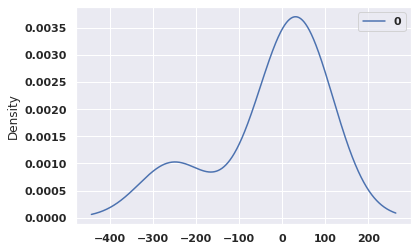

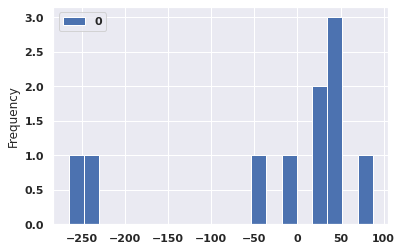

In [105]:
# ax2= angle_df.plot()
ax2=angle_df.plot.kde()
# plt.savefig(image_path,bbox_inches='tight')
ax2=angle_df.plot.hist(bins=20)
# plt.savefig(image_path,bbox_inches='tight')

In [106]:
# ## Plotting the angle distribution. 
# frequency_extraction_array = np.array(angle_list).reshape(-1,1)
# x_d = np.linspace(-2, 2, 800)
# #     """ # This is for the x axis,but mostly used for quering by KernelDensity
# #     and as a resolution.
# #     """
# ###-------------------------OPTIMUM BANDWIDTH -----------------------------------------
# # from sklearn.model_selection import GridSearchCV
# # from sklearn.neighbors import KernelDensity
# # #todo: improvise the bandwidth sampling range be automating it according to the data type.
# # grid = GridSearchCV(KernelDensity(),{'bandwidth':np.linspace(0,1.0,20)},cv = 2)
# # grid.fit(frequency_extraction_array[:, ])
# # bandwidth = float(grid.best_params_['bandwidth'])
# # print(grid.best_params_)


# bandwidth = 10
# ###------------------------ APPLYING THE MODE----------------------------------------

# ### Here we are trying to take the frequency data and fit the data .
# kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(frequency_extraction_array)
# #using tophat kernel (rectangular)
# # kde = KernelDensity(kernel='tophat', bandwidth=bandwidth).fit(frequency_extraction_array)
# logprob = kde.score_samples(x_d[:, None])  ### score_samples is basicall log normal density dist.
# exp_logprob = np.exp(logprob)
# pdf_sample_mean = np.mean(exp_logprob)
# pdf_sample_std = np.std(exp_logprob)
# plt.fill_between(x_d, (exp_logprob),
#                  alpha=0.5)  ### So, here, we find the exp(lognorm) for getting the standard normal distribution
# plt.xlabel('Right Turn Angular Velocity rad/sec')
# plt.ylabel("Non-Parametric KDE estimated values")
# plt.title("Non-parametric KDE for Right turn angular velocity")
# plt.show()